PCA

conda create -n pca --> 
conda activate pca

In [54]:
#epsilon for differential privacy
epsilon=10

#desired_variance = 1 - maximum information loss 
desired_variance = 0.98
#KNN number of neighbors
k=50

#KNN distance metric ['euc', 'sqd', 'max', 'cab']
distance_metric = 'euc'

In [55]:
# Temporary fix to kernel not responding
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Import necessary libraries
import torch
import sklearn.metrics as metrics
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

## Define data paths

In [56]:
file_path_t = f'../epsilon{epsilon}/test.data'
file_path_v = f'../epsilon{epsilon}/val.data'
file_path_s = f'../epsilon{epsilon}/gene.data'
file_path_tr = f'../epsilon{epsilon}/real.data'

## Define custom datasets
One is for the positive and negative examples and another for the synthetic data

In [57]:
from torch.utils.data import Dataset

class TrajectoryDataset(Dataset):
    def __init__(self, data, labels):
        '''
            Dataset for the real train and test data.
            ## Inputs:
            - data: tensor with the trajectories of shape (N, L). N being the number of trajectories and L the length of each trajectory
            - labels: tensor of shape (N). N being the number of trajectories. It can be either one or zero, depending on if its is positive or negative.
        '''
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class SyntheticDataset(Dataset):
    def __init__(self, data):
        '''
            Dataset for the synthetic data obtained from a generator model.
            ## Inputs:
            - data: tensor with the synthetic trajectories of shape (N, L). N being the number of trajectories and L the length of each trajectory
        '''
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [58]:
data_test = pd.read_csv(file_path_t, sep=" ", header=None)
data_test = torch.unique(torch.Tensor(data_test.values), dim=0)

data_validation = pd.read_csv(file_path_v, sep=" ", header=None)
data_validation = torch.unique(torch.Tensor(data_validation.values), dim=0)

data_negative  = torch.cat([data_test, data_validation])

data_synthetic = pd.read_csv(file_path_s, sep=" ", header=None)
data_synthetic = torch.unique(torch.Tensor(data_synthetic.values), dim=0)

data_train = pd.read_csv(file_path_tr, sep=" ", header=None)
data_positive = torch.unique(torch.Tensor(data_train.values), dim=0)

## PCA
We want to perform PCA to the trajectories in order to reduce the dimensionality of the trajectories. First define the functions to perform the singular value decomposition and to display the shape of the tensors.

In [59]:
def perform_svd(data):
    # Compute the SVD where S is the eigenvalues and V is the eigenvectors
    U, S, V = torch.linalg.svd(data)

    return U, S, V

def display_shape(S, V):
    print("Shape of eigenvalues (S):", S.shape)
    print("Shape of eigenvectors (V):", V.shape)

In [60]:
# Perform SVD on the converted DataFrame
U_s, S_s, V_s= perform_svd(data_synthetic)

display_shape(S_s, V_s)

Shape of eigenvalues (S): torch.Size([48])
Shape of eigenvectors (V): torch.Size([48, 48])


Variance of the components

In [61]:
def calculate_cumulative_variance(S):
    # Calculate the variance explained by each principal component
    variance_per_pc = (S ** 2) / torch.sum(S ** 2)

    # Calculate the cumulative variance explained
    cumulative_variance = torch.cumsum(variance_per_pc, dim=0)

    return cumulative_variance

In [62]:
cumulative_variance_synthetic = calculate_cumulative_variance(S_s)

In [63]:
def scree_graph(cumulative_variance_synthetic):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance_synthetic) + 1), cumulative_variance_synthetic, linestyle='-', marker='x', color='blue', label='Synthetic Data')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance')
    plt.legend()
    plt.title('Scree Graph')
    plt.show()

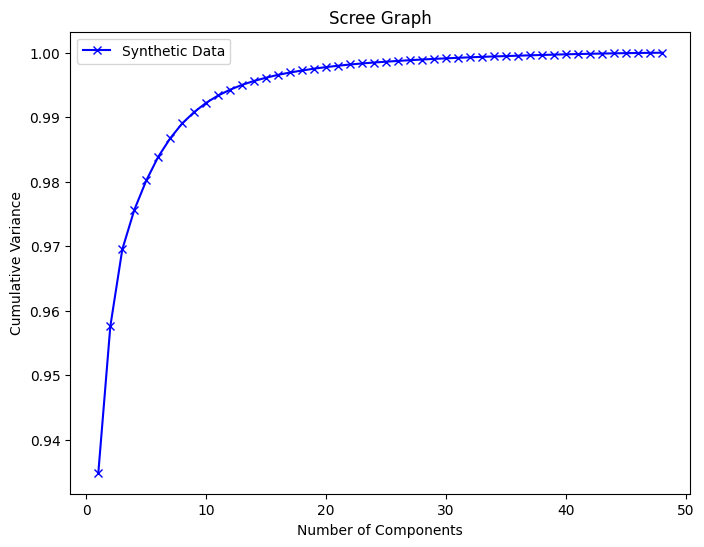

In [64]:
scree_graph(cumulative_variance_synthetic)

In [65]:
def get_num_components(cumulative_variance, desired_variance):
    num_components = torch.sum(cumulative_variance < desired_variance)
    if num_components.item() == 0:
        num_components = torch.tensor(1)
    return num_components.item()

num_components_needed = get_num_components(cumulative_variance_synthetic, desired_variance)
print("Number of principal components needed for a cumulative variance explained of", desired_variance, ":", num_components_needed, " components")

Number of principal components needed for a cumulative variance explained of 0.98 : 4  components


In [66]:
# Project the real_data onto the plane formed by the principal components
new_coordinates_positive = torch.matmul(data_positive,V_s[:, :num_components_needed])
labels_positive = torch.ones(len(data_positive.data))  # Label real data with 1
positive = TrajectoryDataset(new_coordinates_positive, labels_positive)

# Project the synthetic onto the plane formed by the principal components
new_coordinates_synthetic = torch.matmul(data_synthetic,V_s[:, :num_components_needed])
synthetic = SyntheticDataset(new_coordinates_synthetic)

# Project the positive onto the plane formed by the principal components
new_coordinates_negative = torch.matmul(data_negative,V_s[:, :num_components_needed])
labels_negative = torch.ones(len(data_negative.data))  # Label real data with 0
negative = TrajectoryDataset(new_coordinates_negative, labels_negative)

### Comparing the first and second principal components
A study to know the similituds between the first and second principal components

In [88]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
pca = KernelPCA(num_components_needed, kernel='cosine')
synthetic_pca = pca.fit_transform(synthetic.data)
negative_pca = pca.fit_transform(negative.data)
positive_pca = pca.fit_transform(positive.data)

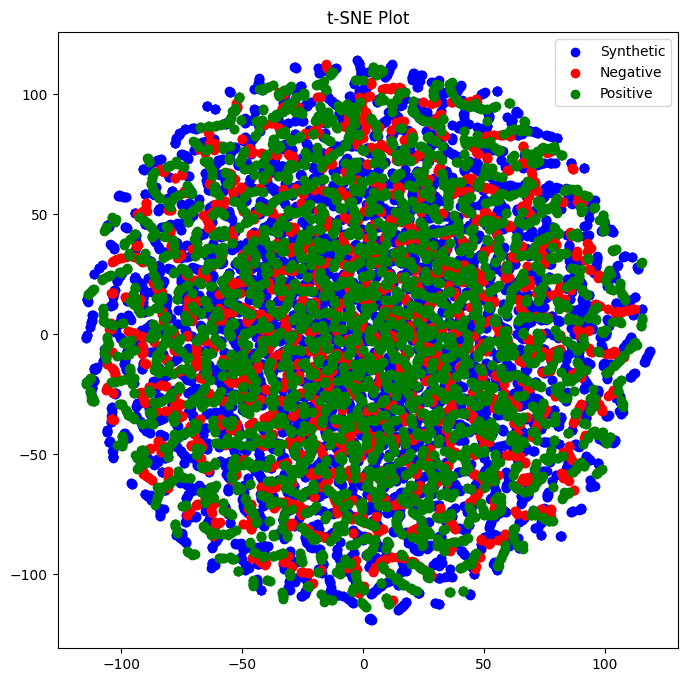

In [75]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
synthetic_tsne = tsne.fit_transform(synthetic_pca)
negative_tsne = tsne.fit_transform(negative_pca)
positive_tsne = tsne.fit_transform(positive_pca)

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Plot t-SNE for synthetic data
plt.figure(figsize=(8, 8))
plt.scatter(synthetic_tsne[:, 0], synthetic_tsne[:, 1], c='blue', label='Synthetic')
plt.scatter(negative_tsne[:, 0], negative_tsne[:, 1], c='red', label='Negative')
plt.scatter(positive_tsne[:, 0], positive_tsne[:, 1], c='green', label='Positive')
plt.title('t-SNE Plot')
plt.legend()
plt.show()

In [89]:
# Plotting the real and synthetic new coordinates
def new_coordinates_comparison(new_coordinates_positive, new_coordinates_synthetic, new_coordinates_negative, num_components_needed):
    if(num_components_needed < 2):
        return
    else:
        plt.figure(figsize=(8, 6))
        plt.scatter(new_coordinates_positive[:, 0], new_coordinates_positive[:, 1], label='Positive', s=1)
        plt.scatter(new_coordinates_synthetic[:, 0], new_coordinates_synthetic[:, 1], label='Synthetic', s=1)
        plt.scatter(new_coordinates_negative[:, 0], new_coordinates_negative[:, 1], label='Negative', s=1)
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.title('New Coordinates on First and Second Principal Components')
        plt.legend()
        plt.show()

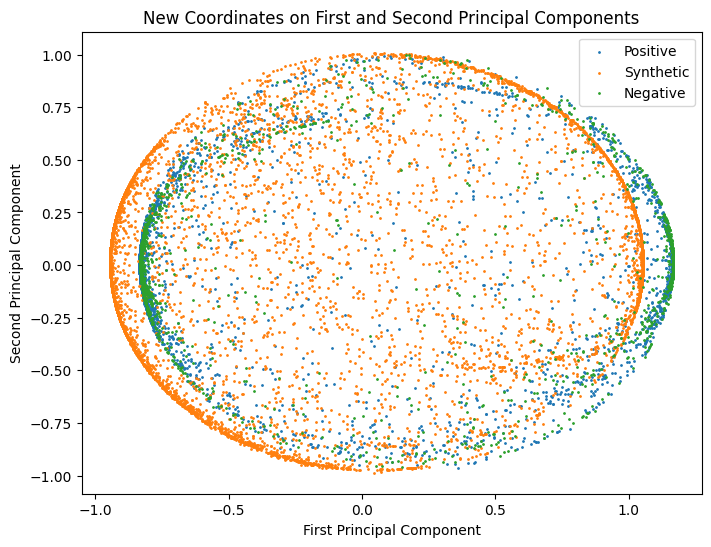

In [90]:
new_coordinates_comparison(positive_pca, synthetic_pca, negative_pca, num_components_needed)

In [70]:
synthetic = SyntheticDataset(synthetic_pca)
negative = TrajectoryDataset(negative_pca, labels=torch.zeros(len(negative_pca)))
positive = TrajectoryDataset(positive_pca, labels=torch.ones(len(positive_pca)))

print(f'Length of synthetic dataset: {synthetic.data.shape}')
print(f'Length of positive dataset: {negative.data.shape}')
print(f'Length of negative dataset: {negative.data.shape}')

Length of synthetic dataset: (8028, 4)
Length of positive dataset: (3380, 4)
Length of negative dataset: (3380, 4)


In [71]:
from torch.utils.data import random_split

#Split synthetic dataset training KNN and testing the whole model 
synthetic_1, synthetic_2 = random_split(synthetic, [math.ceil(0.45*len(synthetic)), math.floor(0.55*len(synthetic))])
negative_train, negative_test = random_split(negative, [math.ceil(0.7*len(negative)), math.floor(0.3*len(negative))]) #negative has to be split into 70-30

training_dataset =TrajectoryDataset(torch.cat([synthetic_2.dataset[synthetic_2.indices], negative_train.dataset[negative_train.indices][0]]), torch.cat([torch.ones(len(synthetic_2)), torch.zeros(len(negative_train))]))

#half negative half positive
testing_dataset = TrajectoryDataset(torch.cat([negative_test.dataset[negative_test.indices][0], positive.data]), torch.cat([torch.zeros(len(positive)), torch.ones(len(negative_test))]))

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

In [ ]:
# Create an instance of the KNN class
knn = KNN(distance_metric)

# Fit the KNN model with the synthetic data
knn.fit(synthetic_1.dataset[synthetic_1.indices])

train_dist, train_idx, train_labels = knn.predict(training_dataset, k)
test_dist, test_idx, test_labels = knn.predict(testing_dataset, k)

SVM

In [ ]:
#RBF SVM Classifier
rbfSVMClassifier = svm.SVC(kernel='poly', probability=True) # RBF Kernel

#Train the model using the training sets
rbfSVMClassifier.fit(train_dist.tolist(), train_labels.tolist())

#Predict the response for test dataset
rbf_y_pred = rbfSVMClassifier.predict(test_dist.tolist())
rbf_y_pred = torch.Tensor(rbf_y_pred)


In [ ]:
#Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100,random_state=0)

#Train the model using the training sets
clf.fit(train_dist.tolist(), train_labels.tolist())

#Predict the response for test dataset
randomForest_y_pred = clf.predict(test_dist.tolist())
randomForest_y_pred = torch.Tensor(randomForest_y_pred)

In [ ]:
y_test = testing_dataset.labels
all_data = testing_dataset.data

TESTS

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
def mia_test(y_pred, y_test, estimator_name):
    y_pred= y_pred.tolist()
    y_test = y_test.tolist()

    # Plot the ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_curve_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=estimator_name)
    roc_curve_display.plot()
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.show()

    # Model ROC AUC Score: what percentage of positive tuples are labelled as such?
    print("ROC AUC Score:",metrics.roc_auc_score(y_test, y_pred))

    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(y_test, y_pred))

    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:",metrics.recall_score(y_test, y_pred))

    # Model F1 Score: what percentage of positive tuples are labelled as such?
    print("F1 Score:",metrics.f1_score(y_test, y_pred))

    # Model Confusion Matrix
    cm=metrics.confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:",)
    cmd=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0', '1'])
    cmd.plot()
    plt.savefig(f'confusion_matrix_{estimator_name}.png')
    plt.show()


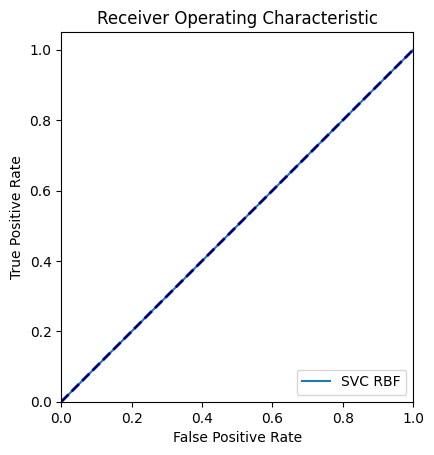

ROC AUC Score: 0.5
Accuracy: 0.13423351866560762
Precision: 0.13423351866560762
Recall: 1.0
F1 Score: 0.23669467787114845
Confusion Matrix:


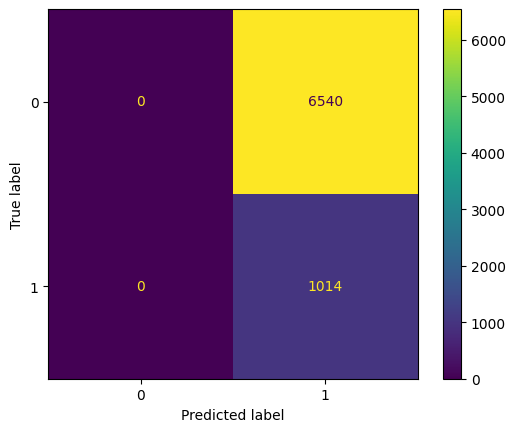

In [ ]:
#SVC RBF
mia_test(rbf_y_pred, y_test, 'SVC RBF')

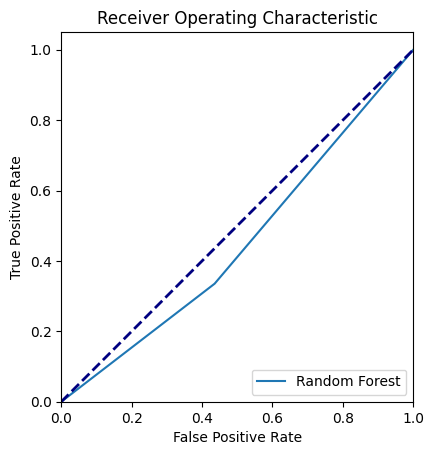

ROC AUC Score: 0.4498394043030599
Accuracy: 0.5336245697643632
Precision: 0.1066164941988084
Recall: 0.33530571992110453
F1 Score: 0.1617891981917678
Confusion Matrix:


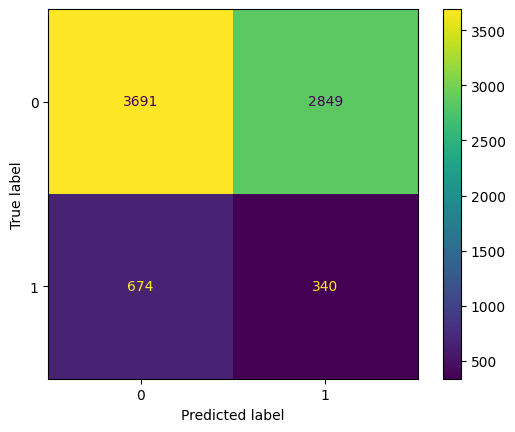

In [ ]:
#Random Forest
mia_test(randomForest_y_pred, y_test, 'Random Forest')

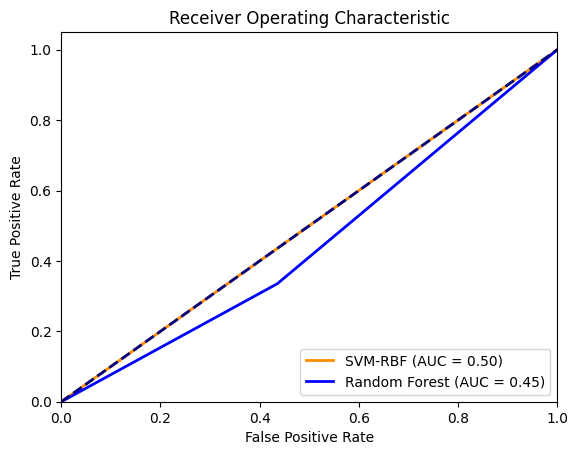

In [ ]:
# Calculate ROC curve and AUC for SVM-RBF
fpr_rbf, tpr_rbf, thresholds = metrics.roc_curve(y_test, rbf_y_pred)
roc_auc_rbf = metrics.auc(fpr_rbf, tpr_rbf)

# Calculate ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, randomForest_y_pred)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

# Plotting both ROC curves on the same graph
plt.figure()

# SVM-RBF ROC curve
plt.plot(fpr_rbf, tpr_rbf, color='darkorange', lw=2, label=f'SVM-RBF (AUC = {roc_auc_rbf:.2f})')

# Random Forest ROC curve
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Random guessing line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Graph formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC.png')
plt.show()